We are trying to explain the reason why there is difference in space and time with the baseline. Is it chance ? Or is it specific to space 
or time ?

In [241]:
import sqlite3
import pandas as pd
import numpy as np
import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../networks/')
from functions.feat_network import get_edge_node_table, filter_edge_table
from functions.feat_visualization import sygma_graph
from functions.datamodel import OptimumParameter
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score
from dotenv import load_dotenv
import scipy.stats as stats

from functions.feat_network import get_edge_node_table, filter_edge_table
from functions.feat_visualization import sygma_graph, sygma_graph_leiden
import random
from sklearn.metrics import adjusted_rand_score


In [242]:
pd.options.mode.chained_assignment = None

In [243]:
import sqlite3
import pandas as pd
import numpy as np
import os
import polars as pl

import random
random.seed(42)

import sys

sys.path.append('../')
sys.path.append('../src')
from functions.feat_network import get_edge_node_table, filter_edge_table
from functions.feat_visualization import sygma_graph_leiden
from functions.datamodel import OptimumParameter
from tqdm import tqdm
from sklearn.metrics import adjusted_rand_score
from dotenv import load_dotenv
import scipy.stats as stats


In [244]:
# Load the environment variables from the .env file
dotenv_path = os.path.join('../', '.env')
load_dotenv(dotenv_path)

True

In [245]:
from optimal_clustering import optimal_clustering

dict_op = optimal_clustering
dict_op = OptimumParameter(**dict_op)

In [246]:
conn = sqlite3.connect("../database.db")
conn_full_db = sqlite3.connect(os.getenv("FULL_DB_PATH"))


df_baseline = pd.read_sql("SELECT * FROM optimal_partition_100_europe", conn)
df_baseline = df_baseline.rename(columns = {'community':'community_baseline'})

In [247]:

#optimal_parameters = pd.read_sql("SELECT * FROM optimization", conn)
#optimal_parameters = optimal_parameters.sort_values("mean", ascending=False)

#dict_op = optimal_parameters.iloc[0].to_dict()
#dict_op = OptimumParameter(**dict_op)

In [248]:
df_ind = pd.read_sql("SELECT * FROM individual_id_cleaned_occupations", conn)
all_individuals = list(set(df_ind.wikidata_id))

We compute different clusetring for different sizes of samples of individuals

In [249]:
df_ind_regions = pd.read_sql("SELECT * FROM temporal_data", conn)
df_ind_regions = df_ind_regions[['wikidata_id', 'region_code']].drop_duplicates()

For every region, compute the distance to the baseline ARI

In [250]:
from region_filters import columns_eu_unique, columns_non_eu_unique

In [251]:
columns_to_keep = columns_eu_unique + columns_non_eu_unique
#columns_to_keep = [region for region in columns_to_keep if region != 're_korea']

#columns_to_keep.remove('re_korea')
#columns_to_keep.remove('re_south_east_asia')

df_regions = pd.merge(df_ind_regions, df_ind, on = 'wikidata_id')
df_regions = df_regions[df_regions['region_code'].isin(columns_to_keep)]
df_regions_name = pd.read_sql_query(
    "SELECT * FROM regions", conn_full_db
)

df_regions = pd.merge(df_regions, df_regions_name, on = 'region_code')
df_regions = df_regions.drop('region_code', axis=1)
df_regions = df_regions.rename(columns = {'region_name':'region_code'})
df_regions = df_regions.drop_duplicates()

In [252]:
df_regions.region_code.value_counts()

German world        7863
France              5180
United Kingdom      4169
Italy               2905
Central Europe      2847
Nordic countries    1904
Slav world          1354
Low countries       1192
Spain               1009
Greek World          456
Arabic world         363
Chinese world        210
Persian world        202
Japan                162
Indian world          66
Korea                 11
South East Asia       10
Name: region_code, dtype: int64

In [253]:
min_individuals = 30

In [254]:
final_list = []
for region in list(set(df_regions['region_code'])):
    
    try:
        df_sample = df_regions[df_regions['region_code']==region]
        df_sample = df_sample[['wikidata_id', 'meta_occupation']]
        len_individuals = len(set(df_sample['wikidata_id']))
        
        if len_individuals <=min_individuals:
            continue

        print(region, len_individuals)

        df_sample.columns = ["source", "target"]
        df_sample["weight"] = 1

        # Draw the graph
        df_sample = pl.from_pandas(df_sample)

        df_edge, df_nodes = get_edge_node_table(df_sample)

        df_edge_filter = df_edge[df_edge["weight"] >= 0]
        df_edge_filter = df_edge_filter[df_edge_filter["source"] != df_edge_filter["target"]]
        df_edge_filter = df_edge_filter[df_edge_filter["rank_count"] <= dict_op.n_neighbours]

        df_partition, g  = sygma_graph_leiden(
            df_edge_filter,
            df_nodes,
            edge_bins=10,
            node_bins=10,
            filepath="../cache/cache_graph.html",
        )    

        new_df = pd.merge(df_baseline, df_partition, on = 'node')
        ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))
        final_list.append({'sample_length':len_individuals, 'ari':ari, 'region':region})
    except:
        pass

final_df = pd.DataFrame(final_list)
final_df = final_df.sort_values('ari', ascending=False)

France 3670
Central Europe 2053
Persian world 97
United Kingdom 2958
Spain 724
Slav world 966
Indian world 40
Japan 136
Nordic countries 1378
Low countries 834
German world 5638
Italy 1988
Chinese world 127
Greek World 242
Arabic world 201


Display the distance, add a regresion line and add labels

## plot with labels

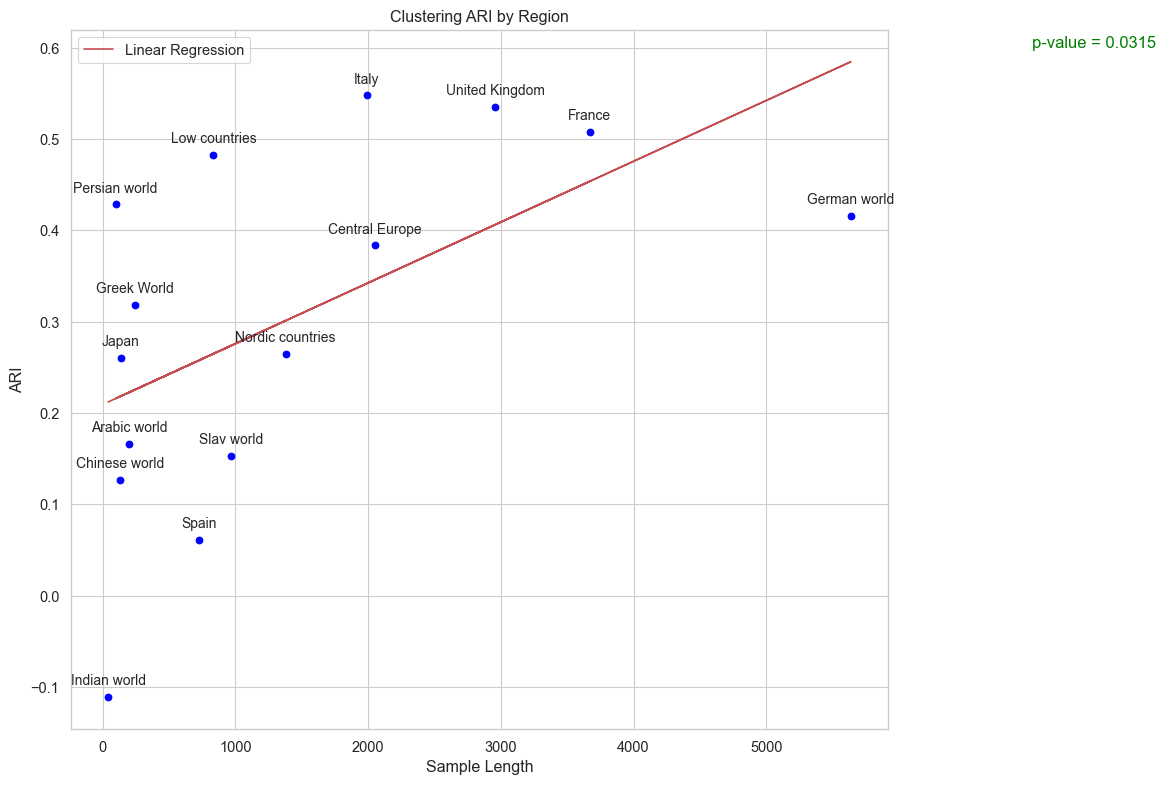

In [255]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

sample_lengths = [entry for entry in final_df['sample_length']]
ari_values = [entry for entry in final_df['ari']]
regions = [entry for entry in final_df['region']]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(sample_lengths, ari_values, color='blue')

# Add labels for each point
for i, region in enumerate(regions):
    plt.text(sample_lengths[i], ari_values[i]+0.01, region, fontsize=10, ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Sample Length')
plt.ylabel('ARI')
plt.title('Clustering ARI by Region')
plt.grid(True)

# Linear regression
X = final_df[['sample_length']]
y = final_df['ari']

X = sm.add_constant(X)  # Adding a constant term to the predictor
model = sm.OLS(y, X).fit()

# Get the p-value from the model summary
p_value = model.pvalues[1]

y_pred = model.predict(X)
plt.plot(X['sample_length'], y_pred, color='r', label='Linear Regression')

# Display p-value on the plot
plt.text(7000, 0.6, f'p-value = {p_value:.4f}', fontsize=12, color='green')

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Compute the same analysis with fake sample of the size of the countries

In [256]:
list(set(df_regions.region_code))

['France',
 'Central Europe',
 'South East Asia',
 'Korea',
 'Persian world',
 'United Kingdom',
 'Spain',
 'Slav world',
 'Indian world',
 'Japan',
 'Nordic countries',
 'Low countries',
 'German world',
 'Italy',
 'Chinese world',
 'Greek World',
 'Arabic world']

In [271]:
"""
import random

list_individuals = list(set(df_regions.wikidata_id))

df_regions = pd.merge(df_ind_regions, df_ind, on = 'wikidata_id')
df_regions = df_regions[df_regions['region_code'].isin(columns_to_keep)]
df_regions_name = pd.read_sql_query(
    "SELECT * FROM regions", conn_full_db
)

df_regions = pd.merge(df_regions, df_regions_name, on = 'region_code')
df_regions = df_regions.drop('region_code', axis=1)
df_regions = df_regions.rename(columns = {'region_name':'region_code'})


"""
final_list = []
list_individuals = list(set(df_regions.wikidata_id))
for region in list(set(df_regions['region_code'])):
    
    try:
        df_region_filter = df_regions[df_regions['region_code']==region]
        len_ind_region = len(set(df_region_filter['wikidata_id']))

        list_individuals_sample = random.sample(list_individuals, len_ind_region)
        df_sample = df_regions[df_regions['wikidata_id'].isin(list_individuals_sample)]
        df_sample = df_sample[['wikidata_id', 'meta_occupation']]
        len_individuals = len(set(df_sample['wikidata_id']))
        
        if len_individuals <= min_individuals:
            continue
            
        print(region, len_individuals)

        df_sample.columns = ["source", "target"]
        df_sample["weight"] = 1

        # Draw the graph
        df_sample = pl.from_pandas(df_sample)
        df_edge, df_nodes = get_edge_node_table(df_sample)
        df_edge_filter = df_edge[df_edge["weight"] >= 0]
        df_edge_filter = df_edge_filter[df_edge_filter["source"] != df_edge_filter["target"]]
        df_edge_filter = df_edge_filter[df_edge_filter["rank_count"] <= dict_op.n_neighbours]

        df_partition, g  = sygma_graph_leiden(
            df_edge_filter,
            df_nodes,
            edge_bins=10,
            node_bins=10,
            filepath="../cache/cache_graph.html",
        )

        new_df = pd.merge(df_baseline, df_partition, on = 'node')
        ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))
        final_list.append({'sample_length':len_individuals, 'ari':ari, 'region':region})
    except:
        pass

final_df_sample = pd.DataFrame(final_list)
final_df_sample['region'] = final_df_sample['region'] + '_sample'
final_df_sample = final_df_sample.rename(columns = {'ari':'ari_sample', 'region':'region_sample'})
df_plot = pd.merge(final_df, final_df_sample, on = 'sample_length')

France 3670
Central Europe 2053
Persian world 97
United Kingdom 2958
Spain 724
Slav world 966
Indian world 40
Japan 136
Nordic countries 1378
Low countries 834
German world 5638
Italy 1988
Chinese world 127
Greek World 242
Arabic world 201


#### Plot Both

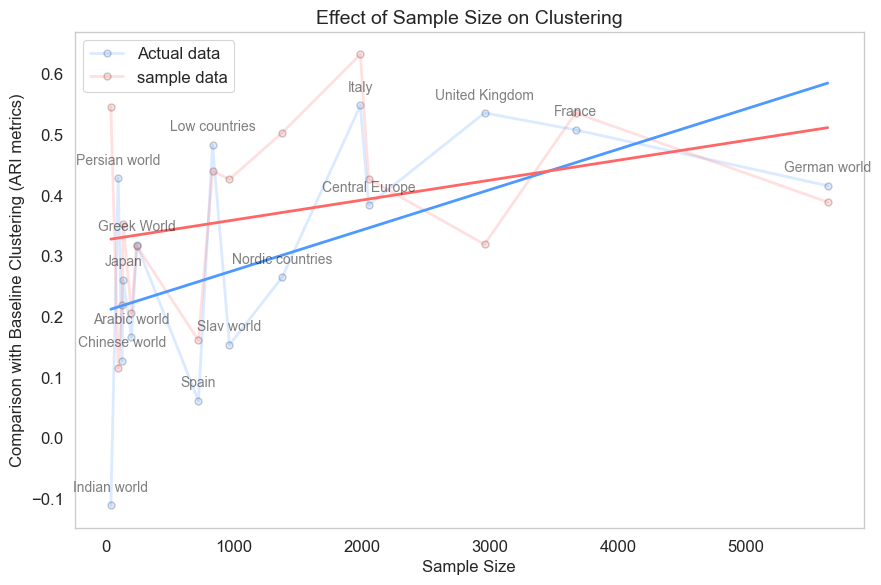

In [272]:
# Separate 'ari' and 'ari_sample' values into two lists
df_plot = df_plot.sort_values('sample_length')
ari_values = df_plot['ari']
ari_sample_values = df_plot['ari_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05

# Extracting data from the DataFrame
sample_length = df_plot['sample_length']
ari = df_plot['ari']
ari_sample = df_plot['ari_sample']
region_sample = df_plot['region_sample']
region = df_plot['region']

import seaborn as sns  # Import seaborn for improved style

# Sort the DataFrame by 'sample_length'
df_plot = df_plot.sort_values(by='sample_length')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
#ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)


# Creating the line plot for 'ari_sample' with a light red color
#ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2)
ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)


# Adding labels and title
ax.set_xlabel('Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)

# Add labels with region names on actual data points
for x, y_ari, y_ari_sample, region in zip(df_plot['sample_length'], df_plot['ari'], df_plot['ari_sample'], df_plot['region']):
    ax.annotate(region, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black', alpha = 0.5)
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
# Add linear regression
X = sm.add_constant(sample_length)  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 3)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 3)

plt.plot(df_plot['sample_length'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot['sample_length'], model_2.predict(X), color=light_red, label='Linear Regression', linewidth='2')

ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'sample data'])
                                           #f"Linear Regression Actual (p = {p_value}**)", 
                                           #f"Linear Regression Sample (p= {p_value_2}*)"])

# Adjust layout and save the plot as an image (optional)
plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()

### Plot the logs

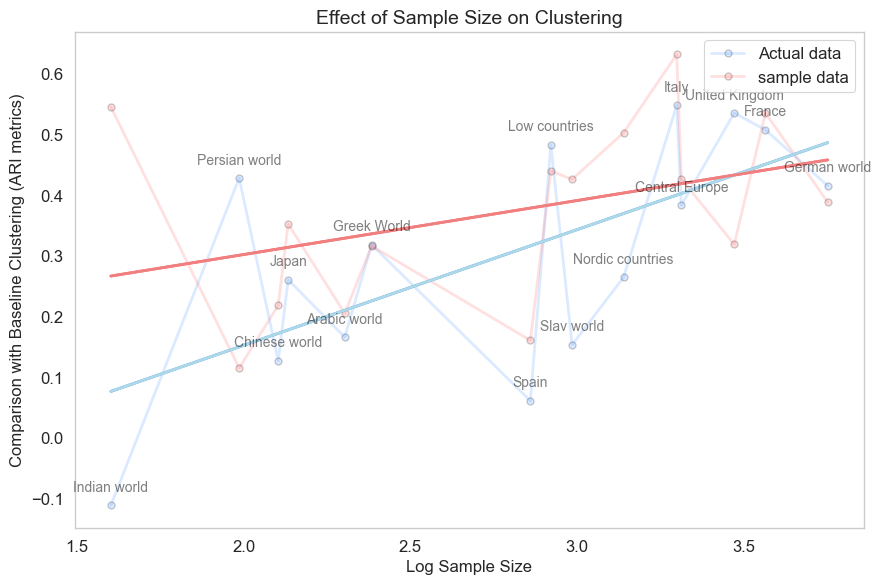

In [273]:
# Extracting data from the DataFrame
sample_length = np.log10(df_plot['sample_length'])
ari = df_plot['ari']
ari_sample = df_plot['ari_sample']
region_sample = df_plot['region_sample']
region = df_plot['region']
df_plot['log_size'] = np.log10(df_plot['sample_length'])

import seaborn as sns  # Import seaborn for improved style

# Sort the DataFrame by 'sample_length'
df_plot = df_plot.sort_values(by='log_size')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
#ax.plot(df_plot['sample_length'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2)
ax.plot(df_plot['log_size'], df_plot['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
#ax.plot(df_plot['sample_length'], df_plot['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2)
ax.plot(df_plot['log_size'], df_plot['ari_sample'], label='ari_sample', color=light_red, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)


# Adding labels and title
ax.set_xlabel('Log Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)


# Add a legend

# Add labels with region names on actual data points
for x, y_ari, y_ari_sample, region in zip(df_plot['log_size'], df_plot['ari'], df_plot['ari_sample'], df_plot['region']):
    ax.annotate(region, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black', alpha = 0.5)
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')

    
    
# Add linear regression
X = sm.add_constant(sample_length)  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 3)

# Get coefficients instead of p-values
coeff_1 = round(model.params[1], 3)
coeff_2 = round(model_2.params[1], 3)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 3)

plt.plot(df_plot['log_size'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot['log_size'], model_2.predict(X), color=light_red, label='Linear Regression', linewidth='2')

plt.plot(df_plot['log_size'], model.predict(X), color='lightblue', label=f'Linear Regression (Coeff: {coeff_1})', linewidth=2)
plt.plot(df_plot['log_size'], model_2.predict(X), color='lightcoral', label=f'Linear Regression (Coeff: {coeff_2})', linewidth=2)


ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'sample data'])
                                            #f'Linear Regression (Coeff: {coeff_1})',
                                            #f'Linear Regression (Coeff: {coeff_2})'])


    # Set new x-axis tick positions and labels
#new_xticks = list(df_plot['sample_length'])  # Use 'size' column for x-axis ticks
#print(new_xticks)
#plt.xticks(log_size, new_xticks)
# Adjust layout and save the plot as an image (optional)
plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()


### Baseline Century

In [260]:
df_ind_time = pd.read_sql("SELECT * FROM temporal_data", conn)
df_ind_time = df_ind_time[['wikidata_id', 'century']].drop_duplicates()
df_ind_time = df_ind_time.rename(columns = {'century':'time'})

print(df_ind_time.time.value_counts().head(5))
df_time =  pd.merge(df_ind_time, df_ind, on = 'wikidata_id')

1800    15383
1700     3378
1600     1520
1500      754
1400      168
Name: time, dtype: int64


In [261]:
final_list = []
#for time in [600]:
for time in sorted(list(set(df_time.time))):

    df_sample = df_time[df_time['time']==time]
    df_sample = df_sample[['wikidata_id', 'meta_occupation']]

    len_individuals = len(set(df_sample['wikidata_id']))
    
    if len_individuals <= min_individuals:
        continue

    print(time, len_individuals)

    df_sample.columns = ["source", "target"]
    df_sample["weight"] = 1

    # Draw the graph
    df_sample = pl.from_pandas(df_sample)
    df_edge, df_nodes = get_edge_node_table(df_sample)
    df_edge_filter = df_edge[df_edge["weight"] >= 0]
    df_edge_filter = df_edge_filter[df_edge_filter["source"] != df_edge_filter["target"]]
    df_edge_filter = df_edge_filter[df_edge_filter["rank_count"] <= dict_op.n_neighbours]

    df_partition, g =sygma_graph_leiden(
        df_edge_filter,
        df_nodes,
        edge_bins=10,
        node_bins=10,
        filepath=f"../cache/cache_graph_{time}.html",
    )    

    new_df = pd.merge(df_baseline, df_partition, on = 'node')
    ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))
    final_list.append({'sample_length':len_individuals, 'ari':ari, 'time':time})

final_df_time = pd.DataFrame(final_list)
final_df_time = final_df_time.sort_values('time')
final_df_time['log_size'] = np.log10(final_df_time['sample_length']+1)

-400 32
800 41
900 31
1000 56
1100 59
1200 93
1300 88
1400 168
1500 754
1600 1520
1700 3378
1800 15383


## Plot

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


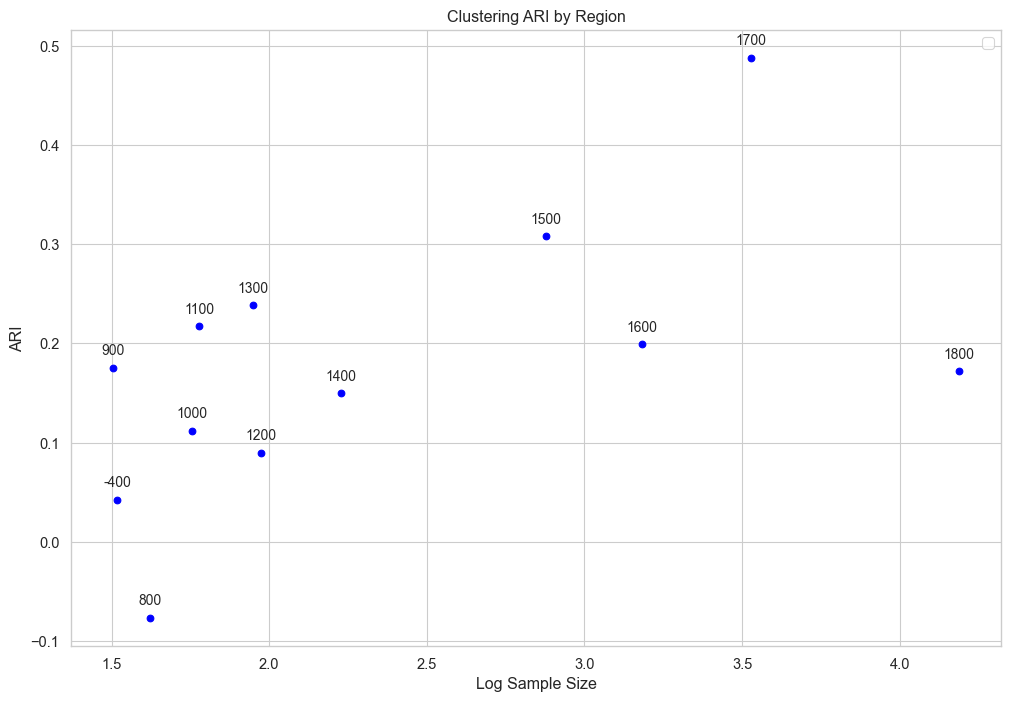

<Figure size 640x480 with 0 Axes>

In [262]:
sample_lengths = [entry for entry in final_df_time['log_size']]
ari_values = [entry for entry in final_df_time['ari']]
times = [entry for entry in final_df_time['time']]

# Create a scatter plot
plt.figure(figsize=(12, 8))
plt.scatter(sample_lengths, ari_values, color='blue')

# Add labels for each point
for i, time in enumerate(times):
    plt.text(sample_lengths[i], ari_values[i]+0.01, time, fontsize=10, ha='center', va='bottom')

# Set plot labels and title
plt.xlabel('Log Sample Size')
plt.ylabel('ARI')
plt.title('Clustering ARI by Region')
plt.grid(True)


plt.legend()
plt.grid(True)
plt.show()

# Show the plot
plt.tight_layout()
plt.show()

In [263]:
import random

list_individuals = list(set(df_time.wikidata_id))

final_list = []
for time in list(set(df_time['time'])):
    
    try:
    
        df_time_filter = df_time[df_time['time']==time]
        len_ind_time = len(set(df_time_filter['wikidata_id']))

        list_individuals_sample = random.sample(list_individuals, len_ind_time)
        df_sample = df_time[df_time['wikidata_id'].isin(list_individuals_sample)]
        df_sample = df_sample[['wikidata_id', 'meta_occupation']]

        len_individuals = len(set(df_sample['wikidata_id']))
        
        if len_individuals <= 30:
            continue

        print(time, len_individuals)


        df_sample.columns = ["source", "target"]
        df_sample["weight"] = 1

        # Draw the graph
        df_sample = pl.from_pandas(df_sample)

        df_edge, df_nodes = get_edge_node_table(df_sample)

        df_edge_filter = filter_edge_table(
            df_edge,
            edge_rule=dict_op.edge_rule,
            top_directed_neighbours=dict_op.n_neighbours,
            normalize_on_top=False,
            min_count_link=0,
        )

        df_partition, g = sygma_graph(
            df_edge_filter,
            df_nodes,
            edge_bins=10,
            node_bins=10,
            resolution=dict_op.resolution,
            filepath="../cache/cache_graph.html",
        )    

        from sklearn.metrics import adjusted_rand_score

        new_df = pd.merge(df_baseline, df_partition, on = 'node', how ='outer')
        #new_df = pd.merge(df_baseline, df_partition, on = 'node')
        new_df = new_df.fillna(4)
        ari = adjusted_rand_score(list(new_df['community']), list(new_df['community_baseline']))

        final_list.append({'sample_length':len_individuals, 'ari':ari, 'time':time})
    except:
        pass
    
final_df_time_sample = pd.DataFrame(final_list)
final_df_time_sample = final_df_time_sample.sort_values('time')
final_df_time_sample = final_df_time_sample.rename(columns = {'ari':'ari_sample', 'time':'time_sample'})
df_plot_sample = pd.merge(final_df_time_sample, final_df_time, on = ['sample_length'])
df_plot_sample['log_size'] = np.log10(df_plot_sample['sample_length']+1)

df_plot_sample = df_plot_sample[df_plot_sample['sample_length']>10]

900 31
1800 15383
1300 88
800 41
1700 3378
1200 93
1600 1520
1100 59
1500 754
1000 56
-400 32
1400 168


Plot the T statistics

In [264]:

ari_values = df_plot_sample['ari']
ari_sample_values = df_plot_sample['ari_sample']

# Perform a two-sample t-test
t_statistic, p_value = stats.ttest_rel(ari_values, ari_sample_values)

# Set the significance level
alpha = 0.05
t_statistic

-0.4558490189778327

0.61408
0.14411


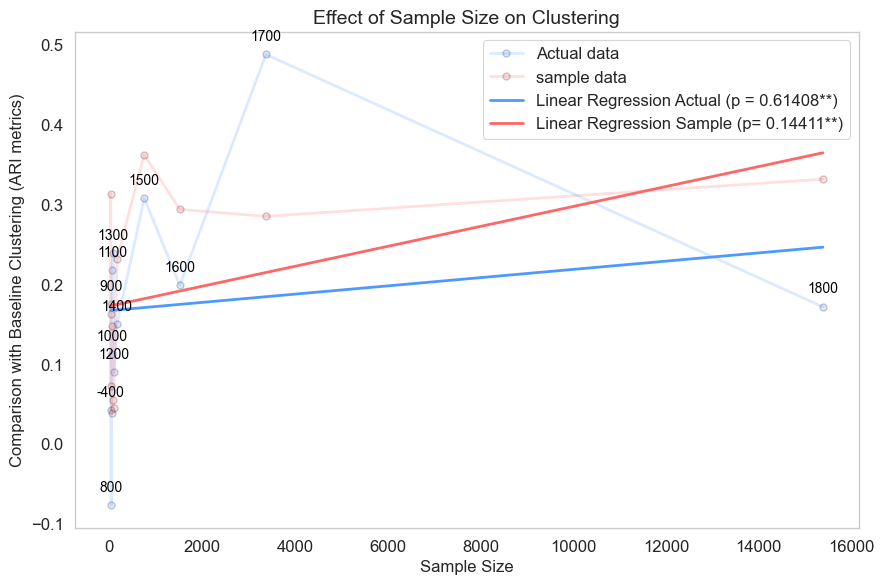

In [265]:
# Extracting data from the DataFrame
sample_length = df_plot_sample['sample_length']
ari = df_plot_sample['ari']
ari_sample = df_plot_sample['ari_sample']
times_sample = df_plot_sample['time_sample']
times = df_plot_sample['time']

# Sort the DataFrame by 'sample_length'
df_plot_sample = df_plot_sample.sort_values(by='sample_length')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
ax.plot(df_plot_sample['sample_length'], df_plot_sample['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
ax.plot(df_plot_sample['sample_length'], df_plot_sample['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)

# Adding labels and title
ax.set_xlabel('Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)



# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'Sample data'])

# Add labels with region names on actual data points
for x, y_ari, time in zip(df_plot_sample['sample_length'], df_plot_sample['ari'], df_plot_sample['time']):
    ax.annotate(time, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
    
# Add linear regression
X = sm.add_constant(list(df_plot_sample['sample_length']))  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 5)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 5)
print(p_value)
print(p_value_2)


plt.plot(df_plot_sample['sample_length'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot_sample['sample_length'], model_2.predict(X), color=light_red, 
         label='Linear Regression', linewidth='2')



ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'sample data', 
                                           f"Linear Regression Actual (p = {p_value}**)", 
                                           f"Linear Regression Sample (p= {p_value_2}**)"])



    # Set new x-axis tick positions and labels
#new_xticks = list(df_plot_sample['sample_length'])  # Use 'size' column for x-axis ticks
#print(new_xticks)
#plt.xticks(log_size, new_xticks)


plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()

0.05649
0.02296


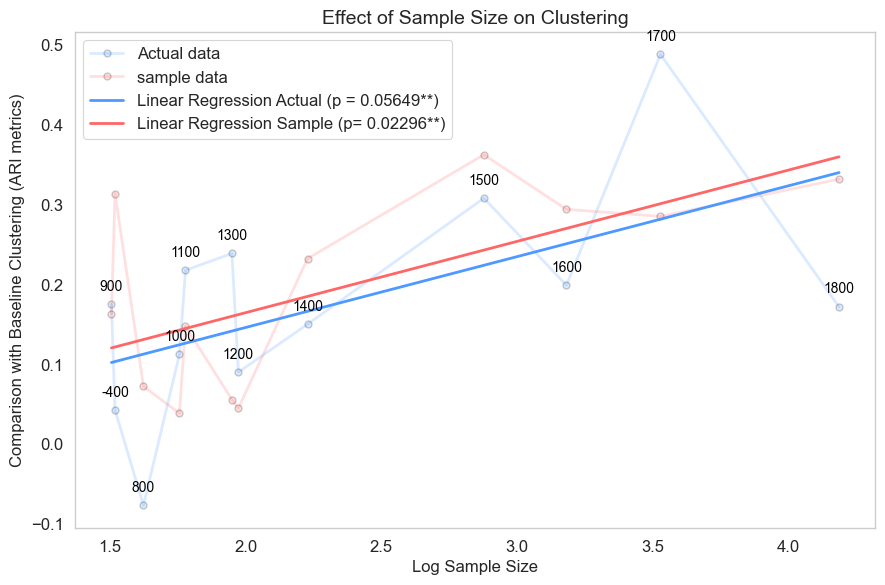

In [266]:
import matplotlib.pyplot as plt
import seaborn as sns  # Import seaborn for improved style


# Extracting data from the DataFrame
log_size = df_plot_sample['log_size']
ari = df_plot_sample['ari']
ari_sample = df_plot_sample['ari_sample']
times_sample = df_plot_sample['time_sample']
times = df_plot_sample['time']

# Sort the DataFrame by 'sample_length'
df_plot_sample = df_plot_sample.sort_values(by='log_size')

# Set the style using seaborn
sns.set(style="whitegrid", context="paper", font_scale=1.2)

# Create the figure and axis objects
fig, ax = plt.subplots(figsize=(9, 6))

# Define lighter colors
light_blue = (0.3, 0.6, 1.0)  # Light blue
light_red = (1.0, 0.4, 0.4)   # Light red

# Creating the line plot for 'ari' with a light blue color
ax.plot(df_plot_sample['log_size'], df_plot_sample['ari'], label='ari', color=light_blue, linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_blue, alpha = 0.2)

# Creating the line plot for 'ari_sample' with a light red color
ax.plot(df_plot_sample['log_size'], df_plot_sample['ari_sample'], label='ari_sample', color=light_red,linestyle='-', linewidth=2, marker='o', markersize=5, markeredgecolor='black', markeredgewidth=1, markerfacecolor=light_red, alpha = 0.2)

# Adding labels and title
ax.set_xlabel('Log Sample Size', fontsize=12)
ax.set_ylabel('Comparison with Baseline Clustering (ARI metrics)', fontsize=12)
ax.set_title('Effect of Sample Size on Clustering', fontsize=14)

# Customize tick labels
ax.tick_params(axis='both', labelsize=12)
ax.grid(False)



# Add a legend
ax.legend(fontsize=12, loc='best', labels=['Actual data', 'Sample data'])

# Add labels with region names on actual data points
for x, y_ari, time in zip(df_plot_sample['log_size'], df_plot_sample['ari'], df_plot_sample['time']):
    ax.annotate(time, (x, y_ari), textcoords="offset points", xytext=(0, 10), ha='center', fontsize=10, color='black')
    #ax.annotate(region, (x, y_ari_sample), textcoords="offset points", xytext=(0, -20), ha='center', fontsize=10, color='red')
    
    
# Add linear regression
X = sm.add_constant(list(df_plot_sample['log_size']))  # Adding a constant term to the predictor
model = sm.OLS(ari, X).fit()
p_value = round(model.pvalues[1], 5)

model_2 = sm.OLS(ari_sample, X).fit()
p_value_2 = round(model_2.pvalues[1], 5)
print(p_value)
print(p_value_2)


plt.plot(df_plot_sample['log_size'], model.predict(X), color=light_blue, 
         label='Linear Regression', linewidth='2')

plt.plot(df_plot_sample['log_size'], model_2.predict(X), color=light_red, 
         label='Linear Regression', linewidth='2')



ax.legend(fontsize=12, loc='best', labels=['Actual data', 
                                           'sample data', 
                                           f"Linear Regression Actual (p = {p_value}**)", 
                                           f"Linear Regression Sample (p= {p_value_2}**)"])


# Set new x-axis tick positions and labels
#new_xticks = list(df_plot_sample['sample_length'])  # Use 'size' column for x-axis ticks
#print(new_xticks)
#plt.xticks(log_size, new_xticks)


plt.tight_layout()
#plt.savefig('line_plot.png', dpi=300)  # Save the plot as an image

# Show the plot
plt.show()